# BirdWatch Timeseries for Location Clusters

## Author: Rosemarie Martienssen

This notebook is the forth in a series of (so far) four. In the first notebook, we cleaned and concatanated Datasets obtained from https://feederwatch.org/explore/raw-dataset-requests/ . The end result was one dataset containing Data ranging between the years 2011-2023. 
The second notebook featured an initial attempt at using timeseries to model bird sightings. The approach from notebook 2 will be mirrored here (with some enhancements) but we will also incorporate the results from Notebook 3, where we used Clustering to identify different locations. The goal is to have a model for each bird species and each location to predict the occurence at the species at the given location.

### Table of contents <a class = "anchor" id = "ToC"></a>
- [Part 0: Import required Python packages and import data](#Part-0)

- [Part 1: Prepare for time series](#Part-1)
 
- [Part 2:Fit and evaluate models using Facebook Prophet](#Part-2)

- [Part 3:Use Facebook Prophet to make predictions for 2024](#Part-3)


### Part 0: Import required Python packages and import  data <a class = "anchor" id = "Part-0"></a>

In [1]:
#import packages

import pandas as pd
import numpy as np

# plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.tsa.seasonal import seasonal_decompose

#FB prophet model
from prophet import Prophet

import time
import random

#For model evaluation
from sklearn.metrics import mean_absolute_error
import math
from sklearn.metrics import mean_squared_error

C:\Users\rmart\.conda\envs\timeseries\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Import the source data for this notebook

df_raw = pd.read_csv("../data/CA_BC_clustered_feederwatch_2011_2023.csv")

C:\Users\rmart\AppData\Local\Temp\ipykernel_144\1433707354.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv("../data/CA_BC_clustered_feederwatch_2011_2023.csv")


In [3]:
df_raw.shape

(515437, 22)

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515437 entries, 0 to 515436
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   LOC_ID                 515437 non-null  object 
 1   LATITUDE               515437 non-null  float64
 2   LONGITUDE              515437 non-null  float64
 3   SUBNATIONAL1_CODE      515437 non-null  object 
 4   SUB_ID                 515437 non-null  object 
 5   OBS_ID                 515437 non-null  object 
 6   Month                  515437 non-null  int64  
 7   Day                    515437 non-null  int64  
 8   Year                   515437 non-null  int64  
 9   PROJ_PERIOD_ID         515437 non-null  object 
 10  alt_full_spp_code      4783 non-null    object 
 11  HOW_MANY               515437 non-null  float64
 12  DAY1_AM                515437 non-null  int64  
 13  DAY1_PM                515437 non-null  int64  
 14  DAY2_AM                515437 non-nu

***
[Back to Table of Contents](#ToC) 
***

### Part 1: prepare for time series <a class = "anchor" id = "Part-1"></a>

**Investigate number of species**

In [5]:
#Display the bird species in observed in BC and how many times they were counted

print(f"There are {df_raw['american_english_name'].nunique()} unique bird species in the data.")

bird_counts = df_raw['american_english_name'].value_counts() #Save into a new df
bird_counts

There are 94 unique bird species in the data.


american_english_name
Dark-eyed Junco           41196
Black-capped Chickadee    31056
Northern Flicker          29753
Song Sparrow              29265
Spotted Towhee            25758
                          ...  
Violet-green Swallow         54
Northern Harrier             50
Hoary Redpoll                47
Hutton's Vireo               44
Bufflehead                   42
Name: count, Length: 94, dtype: int64

Note that the bottom species were only encountered very few times. This may be an issue for the modelling.

**Remove columns**

For our time-series, we will not need the majority of columns currently in the dataframe. We can create a new one that just focuses on the data we need.

In [6]:
#Create a new dataframe and display the first rows

df = df_raw[['date', 'american_english_name', 'HOW_MANY', 'Cluster']]
df.head()

,date,american_english_name,HOW_MANY,Cluster
0,2011-02-07,White-breasted Nuthatch,2.0,4
1,2010-11-22,White-breasted Nuthatch,1.0,0
2,2010-12-02,White-breasted Nuthatch,1.0,4
3,2010-12-09,White-breasted Nuthatch,5.0,4
4,2011-03-06,White-breasted Nuthatch,2.0,3


The `Cluster` column is based on the Location clustering we performed in Notebook 03. We have a total number of 8 clusters in the dataset and will divide the current dataframe into 8 different dataframes to obtain models based on the location.

**Divide into Clusters**

In [7]:
#Create 8 different dataframes for the 8 clusters

for i in range(8):
    globals()[f"df_{i}"] = df[df['Cluster'] == i]


In [8]:
#Sanity Check

df_0.head(2)

,date,american_english_name,HOW_MANY,Cluster
1,2010-11-22,White-breasted Nuthatch,1.0,0
41,2012-12-09,White-breasted Nuthatch,2.0,0


In [9]:
#sanity Check

df_1.head(2)

,date,american_english_name,HOW_MANY,Cluster
16,2012-11-17,White-breasted Nuthatch,1.0,1
234,2011-12-31,White-breasted Nuthatch,1.0,1


In [10]:
#For each of the Clusters, show the bird species that occur most often in the dataframe

for i in range(8):
    print(i)
    display(globals()[f"df_{i}"]['american_english_name'].value_counts().head(5))

0


american_english_name
Dark-eyed Junco           15470
Black-capped Chickadee    15345
Song Sparrow              12511
Spotted Towhee            10996
Anna's Hummingbird        10222
Name: count, dtype: int64

1


american_english_name
Black-capped Chickadee    3994
Downy Woodpecker          2699
Northern Flicker          2550
Red-breasted Nuthatch     2479
Hairy Woodpecker          2132
Name: count, dtype: int64

2


american_english_name
Black-capped Chickadee    4090
Red-breasted Nuthatch     3142
Northern Flicker          3042
Song Sparrow              2262
Downy Woodpecker          2125
Name: count, dtype: int64

3


american_english_name
Dark-eyed Junco              10512
Anna's Hummingbird            9556
Chestnut-backed Chickadee     9279
Spotted Towhee                9184
Northern Flicker              6615
Name: count, dtype: int64

4


american_english_name
Dark-eyed Junco           5766
House Finch               5493
Black-capped Chickadee    4928
Northern Flicker          4780
Song Sparrow              4292
Name: count, dtype: int64

5


american_english_name
Dark-eyed Junco              1561
Black-capped Chickadee       1202
Steller's Jay                1157
Chestnut-backed Chickadee     815
Pine Siskin                   716
Name: count, dtype: int64

6


american_english_name
Spotted Towhee               3904
Dark-eyed Junco              3869
Chestnut-backed Chickadee    3096
Anna's Hummingbird           2856
Song Sparrow                 2800
Name: count, dtype: int64

7


american_english_name
Black-capped Chickadee    798
Blue Jay                  660
Downy Woodpecker          588
Hairy Woodpecker          569
Common Redpoll            517
Name: count, dtype: int64

These results show that there is in fact a difference in the locations because we see different bird patterns, even though there are also some similarities.

**Create Dummy Variables for the bird species**


In [11]:
#Create dummy variables for the column "american_english name" for each location cluster

for i in range(8):
    df = globals()[f"df_{i}"]
    globals()[f"df_dummy_{i}"] = pd.get_dummies(df, columns=['american_english_name'], prefix='no_of', dtype=int)

In [12]:
#For each of the location clusters, show the size of the dataframe and the first row

for i in range(8):
    print(i)
    display(globals()[f"df_dummy_{i}"].shape)
    display(globals()[f"df_dummy_{i}"].head(1))

0


(172310, 93)

,date,HOW_MANY,Cluster,no_of_American Crow,no_of_American Goldfinch,no_of_American Kestrel,no_of_American Robin,no_of_American Tree Sparrow,no_of_Anna's Hummingbird,no_of_Bald Eagle,...,no_of_Varied Thrush,no_of_Violet-green Swallow,no_of_Western Bluebird,no_of_White-breasted Nuthatch,no_of_White-crowned Sparrow,no_of_White-throated Sparrow,no_of_Winter Wren,no_of_Wood Duck,no_of_Yellow-rumped Warbler,no_of_rosy-finch sp.
1,2010-11-22,1.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


1


(29764, 79)

,date,HOW_MANY,Cluster,no_of_American Crow,no_of_American Goldfinch,no_of_American Robin,no_of_American Tree Sparrow,no_of_Bald Eagle,no_of_Barred Owl,no_of_Black-billed Magpie,...,no_of_Townsend's Solitaire,no_of_Varied Thrush,no_of_Violet-green Swallow,no_of_White-breasted Nuthatch,no_of_White-crowned Sparrow,no_of_White-throated Sparrow,no_of_White-winged Crossbill,no_of_Winter Wren,no_of_Yellow-rumped Warbler,no_of_rosy-finch sp.
16,2012-11-17,1.0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


2


(37916, 90)

,date,HOW_MANY,Cluster,no_of_American Crow,no_of_American Goldfinch,no_of_American Kestrel,no_of_American Robin,no_of_American Tree Sparrow,no_of_Anna's Hummingbird,no_of_Bald Eagle,...,no_of_Violet-green Swallow,no_of_Western Bluebird,no_of_White-breasted Nuthatch,no_of_White-crowned Sparrow,no_of_White-throated Sparrow,no_of_White-winged Crossbill,no_of_Wild Turkey,no_of_Winter Wren,no_of_Yellow-rumped Warbler,no_of_rosy-finch sp.
17,2013-03-29,10.0,2,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


3


(131423, 94)

,date,HOW_MANY,Cluster,no_of_American Crow,no_of_American Goldfinch,no_of_American Kestrel,no_of_American Robin,no_of_American Tree Sparrow,no_of_Anna's Hummingbird,no_of_Bald Eagle,...,no_of_Violet-green Swallow,no_of_White-breasted Nuthatch,no_of_White-crowned Sparrow,no_of_White-throated Sparrow,no_of_White-winged Crossbill,no_of_Wild Turkey,no_of_Winter Wren,no_of_Wood Duck,no_of_Yellow-rumped Warbler,no_of_rosy-finch sp.
4,2011-03-06,2.0,3,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


4


(79677, 89)

,date,HOW_MANY,Cluster,no_of_American Crow,no_of_American Goldfinch,no_of_American Kestrel,no_of_American Robin,no_of_American Tree Sparrow,no_of_Anna's Hummingbird,no_of_Bald Eagle,...,no_of_Violet-green Swallow,no_of_Western Bluebird,no_of_White-breasted Nuthatch,no_of_White-crowned Sparrow,no_of_White-throated Sparrow,no_of_White-winged Crossbill,no_of_Winter Wren,no_of_Wood Duck,no_of_Yellow-rumped Warbler,no_of_rosy-finch sp.
0,2011-02-07,2.0,4,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


5


(14232, 74)

,date,HOW_MANY,Cluster,no_of_American Crow,no_of_American Goldfinch,no_of_American Kestrel,no_of_American Robin,no_of_American Tree Sparrow,no_of_Anna's Hummingbird,no_of_Bald Eagle,...,no_of_Song Sparrow,no_of_Spotted Towhee,no_of_Steller's Jay,no_of_Varied Thrush,no_of_White-breasted Nuthatch,no_of_White-crowned Sparrow,no_of_White-throated Sparrow,no_of_White-winged Crossbill,no_of_Winter Wren,no_of_Yellow-rumped Warbler
866,2018-12-02,1.0,5,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


6


(43860, 84)

,date,HOW_MANY,Cluster,no_of_American Crow,no_of_American Goldfinch,no_of_American Kestrel,no_of_American Robin,no_of_American Tree Sparrow,no_of_Anna's Hummingbird,no_of_Bald Eagle,...,no_of_Spotted Towhee,no_of_Steller's Jay,no_of_Townsend's Solitaire,no_of_Varied Thrush,no_of_Violet-green Swallow,no_of_White-breasted Nuthatch,no_of_White-crowned Sparrow,no_of_White-throated Sparrow,no_of_Winter Wren,no_of_Yellow-rumped Warbler
45,2013-03-14,1.0,6,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


7


(6255, 48)

,date,HOW_MANY,Cluster,no_of_American Crow,no_of_American Robin,no_of_American Tree Sparrow,no_of_Bald Eagle,no_of_Black-billed Magpie,no_of_Black-capped Chickadee,no_of_Blue Jay,...,no_of_Red-breasted Nuthatch,no_of_Red-winged Blackbird,no_of_Rock Pigeon (Feral Pigeon),no_of_Ruffed Grouse,no_of_Sharp-shinned Hawk,no_of_Steller's Jay,no_of_White-breasted Nuthatch,no_of_White-crowned Sparrow,no_of_White-throated Sparrow,no_of_White-winged Crossbill
5,2011-11-19,1.0,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Because different bird species appear in different clusters, the number of columns varies across the different dataframes.

The data now represents whether or not a certain species was seen in a day. We will combine the `HOW_MANY` column with the dummy columns `no_of___`

In [13]:
#Multiply the dummy variables by the "How many" column

for i in range(8):
    df = globals()[f"df_dummy_{i}"]
    bird_species = df.columns[3:] # All the columns containing bird species
    for col in bird_species:
        globals()[f"df_dummy_{i}"][col] = df['HOW_MANY'] * df[col]

In [14]:
#Drop the "How Many" column and the "Cluster from each dataframe

for i in range(8):
    df = globals()[f"df_dummy_{i}"]
    globals()[f"df_dummy_{i}"].drop(columns=['HOW_MANY'], inplace=True)
    globals()[f"df_dummy_{i}"].drop(columns=['Cluster'], inplace=True)


In [15]:
df_dummy_0.head()

,date,no_of_American Crow,no_of_American Goldfinch,no_of_American Kestrel,no_of_American Robin,no_of_American Tree Sparrow,no_of_Anna's Hummingbird,no_of_Bald Eagle,no_of_Band-tailed Pigeon,no_of_Barred Owl,...,no_of_Varied Thrush,no_of_Violet-green Swallow,no_of_Western Bluebird,no_of_White-breasted Nuthatch,no_of_White-crowned Sparrow,no_of_White-throated Sparrow,no_of_Winter Wren,no_of_Wood Duck,no_of_Yellow-rumped Warbler,no_of_rosy-finch sp.
1,2010-11-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
41,2012-12-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
87,2011-11-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
88,2011-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
163,2011-04-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


**Fill in missing dates**

We will group the data by the date columns to have one row of data for each day. Furthermore, we will have to fill in any missing dates with zeros in order to have continuos data.

In [16]:
# Group each dataframe by the date column and set it as the new index

for i in range(8):
    df = globals()[f"df_dummy_{i}"]
    globals()[f"df_dummy_{i}"]= df.groupby(['date']).sum()
    globals()[f"df_dummy_{i}"].reset_index().set_index('date')

In [17]:
df_dummy_0.describe()

,no_of_American Crow,no_of_American Goldfinch,no_of_American Kestrel,no_of_American Robin,no_of_American Tree Sparrow,no_of_Anna's Hummingbird,no_of_Bald Eagle,no_of_Band-tailed Pigeon,no_of_Barred Owl,no_of_Bewick's Wren,...,no_of_Varied Thrush,no_of_Violet-green Swallow,no_of_Western Bluebird,no_of_White-breasted Nuthatch,no_of_White-crowned Sparrow,no_of_White-throated Sparrow,no_of_Winter Wren,no_of_Wood Duck,no_of_Yellow-rumped Warbler,no_of_rosy-finch sp.
count,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000,...,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000
mean,11.874314,7.840399,0.001496,4.332668,0.191521,8.251372,0.062344,0.807980,0.011970,0.512219,...,5.906234,0.006983,0.000499,0.074813,4.319701,0.246384,0.012469,0.379551,0.059850,0.010973
std,12.062841,12.805448,0.038662,6.628701,0.636724,9.341206,0.344045,2.795515,0.113273,0.992726,...,8.558078,0.144600,0.022333,0.428977,6.433914,0.655959,0.149330,1.723410,0.660709,0.191848
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,2.000000,0.000000,2.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,16.000000,10.000000,0.000000,6.000000,0.000000,10.000000,0.000000,0.000000,0.000000,1.000000,...,8.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,293.000000,107.000000,1.000000,71.000000,6.000000,70.000000,8.000000,32.000000,2.000000,7.000000,...,143.000000,4.000000,1.000000,5.000000,113.000000,5.000000,4.000000,19.000000,25.000000,5.000000


In [18]:
#For each of the dataframes, save the first and last day in a list to compare timeframes

first_day = []
last_day = []
for i in range(8):
    df = globals()[f"df_dummy_{i}"]
    first = df.index.min()
    last = df.index.max()
    first_day.append(first)
    last_day.append(last)

print(first_day)
print(last_day)
    

['2010-11-01', '2010-11-13', '2010-11-13', '2010-11-13', '2010-11-13', '2010-11-13', '2010-11-13', '2010-11-13']
['2023-04-29', '2023-04-29', '2023-04-29', '2023-04-29', '2023-04-29', '2023-04-29', '2023-04-29', '2023-04-28']


The date ranges are overall very similar. We will work with these ranges and not adjust them additionally by making them all the exact same. Instead, we will just identify missing values for each dataframe within its individual range and fill these dates with zeros. Note that the survey collecting observations is only active in the Winter months, which is why a lot of missing dates during the summer are expected.

In [19]:
#Fill missing dates

for i in range(8):
    df = globals()[f"df_dummy_{i}"]
    
    # Convert the index to DatetimeIndex if it's not already in datetime format
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    full_range = pd.date_range(start=first_day[i], end=last_day[i], freq="D")
    
    # Create a new DataFrame with the full date range and set its index
    df_full = pd.DataFrame(index=full_range)
    
    # Concatenate the existing DataFrame with the full DataFrame along columns
    concatenated_df = pd.concat([df_full, df], axis=1)
    
    # Store the concatenated DataFrame back to the global namespace
    globals()[f"df_daily_{i}"] = concatenated_df.loc[df.index]

In [20]:
df_daily_0.head()

,no_of_American Crow,no_of_American Goldfinch,no_of_American Kestrel,no_of_American Robin,no_of_American Tree Sparrow,no_of_Anna's Hummingbird,no_of_Bald Eagle,no_of_Band-tailed Pigeon,no_of_Barred Owl,no_of_Bewick's Wren,...,no_of_Varied Thrush,no_of_Violet-green Swallow,no_of_Western Bluebird,no_of_White-breasted Nuthatch,no_of_White-crowned Sparrow,no_of_White-throated Sparrow,no_of_Winter Wren,no_of_Wood Duck,no_of_Yellow-rumped Warbler,no_of_rosy-finch sp.
date,,,,,,,,,,,,,,,,,,,,,
2010-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-11-13,10.0,14.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2010-11-14,7.0,6.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-11-15,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
2010-11-16,20.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Fill in missing values with zeros

for i in range(8):
    df = globals()[f"df_daily_{i}"]
    globals()[f"df_clean_{i}"] = df.fillna(0)


In [22]:
df_clean_0.describe()

,no_of_American Crow,no_of_American Goldfinch,no_of_American Kestrel,no_of_American Robin,no_of_American Tree Sparrow,no_of_Anna's Hummingbird,no_of_Bald Eagle,no_of_Band-tailed Pigeon,no_of_Barred Owl,no_of_Bewick's Wren,...,no_of_Varied Thrush,no_of_Violet-green Swallow,no_of_Western Bluebird,no_of_White-breasted Nuthatch,no_of_White-crowned Sparrow,no_of_White-throated Sparrow,no_of_Winter Wren,no_of_Wood Duck,no_of_Yellow-rumped Warbler,no_of_rosy-finch sp.
count,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000,...,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000
mean,11.874314,7.840399,0.001496,4.332668,0.191521,8.251372,0.062344,0.807980,0.011970,0.512219,...,5.906234,0.006983,0.000499,0.074813,4.319701,0.246384,0.012469,0.379551,0.059850,0.010973
std,12.062841,12.805448,0.038662,6.628701,0.636724,9.341206,0.344045,2.795515,0.113273,0.992726,...,8.558078,0.144600,0.022333,0.428977,6.433914,0.655959,0.149330,1.723410,0.660709,0.191848
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,2.000000,0.000000,2.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,16.000000,10.000000,0.000000,6.000000,0.000000,10.000000,0.000000,0.000000,0.000000,1.000000,...,8.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,293.000000,107.000000,1.000000,71.000000,6.000000,70.000000,8.000000,32.000000,2.000000,7.000000,...,143.000000,4.000000,1.000000,5.000000,113.000000,5.000000,4.000000,19.000000,25.000000,5.000000


In [23]:
df_clean_0['no_of_White-breasted Nuthatch'].value_counts()

no_of_White-breasted Nuthatch
0.0    1921
1.0      47
2.0      24
4.0       8
5.0       4
3.0       1
Name: count, dtype: int64

In [24]:
#Check for any missin values

for i in range(8):
    df = globals()[f"df_clean_{i}"]
    print(df.isna().sum().sum())

0
0
0
0
0
0
0
0


#### Convert to weekly data

In [25]:
# Create dataframes to look at weekly data

for i in range(8):
    df = globals()[f"df_clean_{i}"]
    globals()[f"weekly_df_{i}"] = df.resample("W").sum()


***
[Back to Table of Contents](#ToC) 
***

### Part 2: Fit and evaluate Models using Facebook Prophet <a class = "anchor" id = "Part-2"></a>

In the following codeblock, we will be using one big nested for-loop to do the followin:

For each location cluster and each bird species that was encountered in that cluster we will
- Create train and test sets, where the test sets are the Winter Months of 2023
- Train the prophet model
- make predictions for the test set using Prophet
- Calculate the mean bird observations for the Winter months (because no observations are tracked during the summer)
- Evaluate the model using 2 different error metrics, both for our Prophet prediction and for the mean prediction

In [26]:
start_time = time.time()  # Start time

for i in range(8): #loop through locations
    df = globals()[f"weekly_df_{i}"]
    filtered_df = df[
    (df.index.month.isin([11, 12, 1, 2, 3, 4])) & 
    (~((df.index.year == 2022) | (df.index.year == 2023) & (df.index.month.isin([11, 12, 1, 2, 3, 4])))
    )] #df with only the winter months, but not the months we will use in the test data (Avoid leakage!)

    #Instantiate lists for model evaluation
    prophet_mae = []
    mean_mae = []
    prophet_rmse = []
    mean_rmse = []
    
    for species in df.columns: #loop through all the columns (birdspecies) in one location
            
        #Create a prophet dataframe for each of the species
        globals()[f"prophet_df_{i}_{species}"] = df[[species]].copy()
        globals()[f"prophet_df_{i}_{species}"].reset_index(inplace = True)
        globals()[f"prophet_df_{i}_{species}"].rename(columns={'date': 'ds', species: 'y'}, inplace=True)
        prophet_df = globals()[f"prophet_df_{i}_{species}"]

        #Create Train and Test sets
        globals()[f"train_{i}_{species}"] = prophet_df.loc[prophet_df['ds'] <= '2022-10-31']
        globals()[f"test_{i}_{species}"] = prophet_df.loc[prophet_df['ds'] > '2022-10-31']
        train = globals()[f"train_{i}_{species}"]
        test =  globals()[f"test_{i}_{species}"]
        globals()[f"x_train_{i}_{species}"] = train[['ds']]
        globals()[f"y_train_{i}_{species}"] = train[['y']]
        globals()[f"x_test_{i}_{species}"] = test[['ds']]
        globals()[f"y_test_{i}_{species}"] = test[['y']]

        #Instantiate and train the model
        globals()[f"model_{i}_{species}"] = Prophet()
        model = globals()[f"model_{i}_{species}"]
        model.fit(train)

        #Predict on test set
        x_test = globals()[f"x_test_{i}_{species}"] 
        globals()[f"y_pred_{i}_{species}"] = model.predict(x_test)
        
        #Calculate the mean value over the Winter months
        globals()[f"mean_value_{i}_{species}"] = filtered_df[species].mean()
        mean_value = globals()[f"mean_value_{i}_{species}"]
        #Create an array for the mean value in order to plot it
        full_index = pd.concat([train['ds'], test['ds']])   
        globals()[f"baseline_{i}_{species}"] = np.full(full_index.shape, mean_value)
        
        
        #Evaluate model using mean absolute error
        y_pred = globals()[f"y_pred_{i}_{species}"]
        y_test = globals()[f"y_test_{i}_{species}"]
        
        score_mae = mean_absolute_error(y_test, y_pred['yhat']) #Mean absolute error for the prophet model
        prophet_mae.append(score_mae)

        mean = np.full(y_test.shape, mean_value) #Mean absolute error for the Winter mean calc
        score_mae_mean = mean_absolute_error(y_test, mean)
        mean_mae.append(score_mae_mean)

        score_rmse = math.sqrt(mean_squared_error(y_test, y_pred['yhat'])) #Root mean squared error for the prophet model
        prophet_rmse.append(score_rmse)
        score_rmse_mean = math.sqrt(mean_squared_error(y_test, mean))#Root mean squared error for the Winter mean calc
        mean_rmse.append(score_rmse_mean) 

   # Create a dataframe for the different error metrics     
    globals()[f"df_errors_{i}"] = pd.DataFrame({
    'prophet_mae': prophet_mae,
    'mean_mae': mean_mae,
    'prophet_rmse': prophet_rmse,
    'mean_rmse': mean_rmse
})        
    print(f' Cluster {i} done')
        

end_time = time.time()  # End time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

09:02:02 - cmdstanpy - INFO - Chain [1] start processing
09:02:02 - cmdstanpy - INFO - Chain [1] done processing
09:02:03 - cmdstanpy - INFO - Chain [1] start processing
09:02:03 - cmdstanpy - INFO - Chain [1] done processing
09:02:03 - cmdstanpy - INFO - Chain [1] start processing
09:02:03 - cmdstanpy - INFO - Chain [1] done processing
09:02:03 - cmdstanpy - INFO - Chain [1] start processing
09:02:03 - cmdstanpy - INFO - Chain [1] done processing
09:02:04 - cmdstanpy - INFO - Chain [1] start processing
09:02:04 - cmdstanpy - INFO - Chain [1] done processing
09:02:04 - cmdstanpy - INFO - Chain [1] start processing
09:02:04 - cmdstanpy - INFO - Chain [1] done processing
09:02:04 - cmdstanpy - INFO - Chain [1] start processing
09:02:05 - cmdstanpy - INFO - Chain [1] done processing
09:02:05 - cmdstanpy - INFO - Chain [1] start processing
09:02:05 - cmdstanpy - INFO - Chain [1] done processing
09:02:05 - cmdstanpy - INFO - Chain [1] start processing
09:02:05 - cmdstanpy - INFO - Chain [1]

 Cluster 0 done


09:02:34 - cmdstanpy - INFO - Chain [1] start processing
09:02:34 - cmdstanpy - INFO - Chain [1] done processing
09:02:35 - cmdstanpy - INFO - Chain [1] start processing
09:02:35 - cmdstanpy - INFO - Chain [1] done processing
09:02:35 - cmdstanpy - INFO - Chain [1] start processing
09:02:35 - cmdstanpy - INFO - Chain [1] done processing
09:02:35 - cmdstanpy - INFO - Chain [1] start processing
09:02:35 - cmdstanpy - INFO - Chain [1] done processing
09:02:35 - cmdstanpy - INFO - Chain [1] start processing
09:02:36 - cmdstanpy - INFO - Chain [1] done processing
09:02:36 - cmdstanpy - INFO - Chain [1] start processing
09:02:36 - cmdstanpy - INFO - Chain [1] done processing
09:02:36 - cmdstanpy - INFO - Chain [1] start processing
09:02:36 - cmdstanpy - INFO - Chain [1] done processing
09:02:36 - cmdstanpy - INFO - Chain [1] start processing
09:02:37 - cmdstanpy - INFO - Chain [1] done processing
09:02:37 - cmdstanpy - INFO - Chain [1] start processing
09:02:37 - cmdstanpy - INFO - Chain [1]

 Cluster 1 done


09:02:59 - cmdstanpy - INFO - Chain [1] start processing
09:02:59 - cmdstanpy - INFO - Chain [1] done processing
09:02:59 - cmdstanpy - INFO - Chain [1] start processing
09:02:59 - cmdstanpy - INFO - Chain [1] done processing
09:02:59 - cmdstanpy - INFO - Chain [1] start processing
09:03:00 - cmdstanpy - INFO - Chain [1] done processing
09:03:00 - cmdstanpy - INFO - Chain [1] start processing
09:03:00 - cmdstanpy - INFO - Chain [1] done processing
09:03:00 - cmdstanpy - INFO - Chain [1] start processing
09:03:00 - cmdstanpy - INFO - Chain [1] done processing
09:03:00 - cmdstanpy - INFO - Chain [1] start processing
09:03:00 - cmdstanpy - INFO - Chain [1] done processing
09:03:01 - cmdstanpy - INFO - Chain [1] start processing
09:03:01 - cmdstanpy - INFO - Chain [1] done processing
09:03:01 - cmdstanpy - INFO - Chain [1] start processing
09:03:01 - cmdstanpy - INFO - Chain [1] done processing
09:03:01 - cmdstanpy - INFO - Chain [1] start processing
09:03:01 - cmdstanpy - INFO - Chain [1]

 Cluster 2 done


09:03:29 - cmdstanpy - INFO - Chain [1] done processing
09:03:29 - cmdstanpy - INFO - Chain [1] start processing
09:03:29 - cmdstanpy - INFO - Chain [1] done processing
09:03:29 - cmdstanpy - INFO - Chain [1] start processing
09:03:29 - cmdstanpy - INFO - Chain [1] done processing
09:03:30 - cmdstanpy - INFO - Chain [1] start processing
09:03:30 - cmdstanpy - INFO - Chain [1] done processing
09:03:30 - cmdstanpy - INFO - Chain [1] start processing
09:03:31 - cmdstanpy - INFO - Chain [1] done processing
09:03:31 - cmdstanpy - INFO - Chain [1] start processing
09:03:31 - cmdstanpy - INFO - Chain [1] done processing
09:03:31 - cmdstanpy - INFO - Chain [1] start processing
09:03:31 - cmdstanpy - INFO - Chain [1] done processing
09:03:32 - cmdstanpy - INFO - Chain [1] start processing
09:03:32 - cmdstanpy - INFO - Chain [1] done processing
09:03:32 - cmdstanpy - INFO - Chain [1] start processing
09:03:32 - cmdstanpy - INFO - Chain [1] done processing
09:03:33 - cmdstanpy - INFO - Chain [1] 

 Cluster 3 done


09:04:01 - cmdstanpy - INFO - Chain [1] done processing
09:04:01 - cmdstanpy - INFO - Chain [1] start processing
09:04:01 - cmdstanpy - INFO - Chain [1] done processing
09:04:02 - cmdstanpy - INFO - Chain [1] start processing
09:04:02 - cmdstanpy - INFO - Chain [1] done processing
09:04:02 - cmdstanpy - INFO - Chain [1] start processing
09:04:02 - cmdstanpy - INFO - Chain [1] done processing
09:04:02 - cmdstanpy - INFO - Chain [1] start processing
09:04:02 - cmdstanpy - INFO - Chain [1] done processing
09:04:03 - cmdstanpy - INFO - Chain [1] start processing
09:04:03 - cmdstanpy - INFO - Chain [1] done processing
09:04:03 - cmdstanpy - INFO - Chain [1] start processing
09:04:03 - cmdstanpy - INFO - Chain [1] done processing
09:04:03 - cmdstanpy - INFO - Chain [1] start processing
09:04:03 - cmdstanpy - INFO - Chain [1] done processing
09:04:04 - cmdstanpy - INFO - Chain [1] start processing
09:04:04 - cmdstanpy - INFO - Chain [1] done processing
09:04:04 - cmdstanpy - INFO - Chain [1] 

 Cluster 4 done


09:04:30 - cmdstanpy - INFO - Chain [1] done processing
09:04:30 - cmdstanpy - INFO - Chain [1] start processing
09:04:30 - cmdstanpy - INFO - Chain [1] done processing
09:04:30 - cmdstanpy - INFO - Chain [1] start processing
09:04:30 - cmdstanpy - INFO - Chain [1] done processing
09:04:31 - cmdstanpy - INFO - Chain [1] start processing
09:04:31 - cmdstanpy - INFO - Chain [1] done processing
09:04:31 - cmdstanpy - INFO - Chain [1] start processing
09:04:31 - cmdstanpy - INFO - Chain [1] done processing
09:04:31 - cmdstanpy - INFO - Chain [1] start processing
09:04:31 - cmdstanpy - INFO - Chain [1] done processing
09:04:32 - cmdstanpy - INFO - Chain [1] start processing
09:04:32 - cmdstanpy - INFO - Chain [1] done processing
09:04:32 - cmdstanpy - INFO - Chain [1] start processing
09:04:32 - cmdstanpy - INFO - Chain [1] done processing
09:04:32 - cmdstanpy - INFO - Chain [1] start processing
09:04:32 - cmdstanpy - INFO - Chain [1] done processing
09:04:33 - cmdstanpy - INFO - Chain [1] 

 Cluster 5 done


09:04:53 - cmdstanpy - INFO - Chain [1] start processing
09:04:54 - cmdstanpy - INFO - Chain [1] done processing
09:04:54 - cmdstanpy - INFO - Chain [1] start processing
09:04:54 - cmdstanpy - INFO - Chain [1] done processing
09:04:54 - cmdstanpy - INFO - Chain [1] start processing
09:04:54 - cmdstanpy - INFO - Chain [1] done processing
09:04:54 - cmdstanpy - INFO - Chain [1] start processing
09:04:55 - cmdstanpy - INFO - Chain [1] done processing
09:04:55 - cmdstanpy - INFO - Chain [1] start processing
09:04:55 - cmdstanpy - INFO - Chain [1] done processing
09:04:55 - cmdstanpy - INFO - Chain [1] start processing
09:04:55 - cmdstanpy - INFO - Chain [1] done processing
09:04:55 - cmdstanpy - INFO - Chain [1] start processing
09:04:56 - cmdstanpy - INFO - Chain [1] done processing
09:04:56 - cmdstanpy - INFO - Chain [1] start processing
09:04:56 - cmdstanpy - INFO - Chain [1] done processing
09:04:56 - cmdstanpy - INFO - Chain [1] start processing
09:04:56 - cmdstanpy - INFO - Chain [1]

 Cluster 6 done


09:05:21 - cmdstanpy - INFO - Chain [1] start processing
09:05:21 - cmdstanpy - INFO - Chain [1] done processing
09:05:21 - cmdstanpy - INFO - Chain [1] start processing
09:05:21 - cmdstanpy - INFO - Chain [1] done processing
09:05:22 - cmdstanpy - INFO - Chain [1] start processing
09:05:22 - cmdstanpy - INFO - Chain [1] done processing
09:05:22 - cmdstanpy - INFO - Chain [1] start processing
09:05:22 - cmdstanpy - INFO - Chain [1] done processing
09:05:22 - cmdstanpy - INFO - Chain [1] start processing
09:05:22 - cmdstanpy - INFO - Chain [1] done processing
09:05:23 - cmdstanpy - INFO - Chain [1] start processing
09:05:23 - cmdstanpy - INFO - Chain [1] done processing
09:05:23 - cmdstanpy - INFO - Chain [1] start processing
09:05:23 - cmdstanpy - INFO - Chain [1] done processing
09:05:24 - cmdstanpy - INFO - Chain [1] start processing
09:05:24 - cmdstanpy - INFO - Chain [1] done processing
09:05:24 - cmdstanpy - INFO - Chain [1] start processing
09:05:24 - cmdstanpy - INFO - Chain [1]

 Cluster 7 done
Elapsed time: 215.25595808029175 seconds


Using the error dataframes created above, we will calculate our prophet Model performed better than the mean on average for each of the location clusters

In [27]:
#Evaluate model performance for each cluster

for i in range(8):
    df_errors = globals()[f"df_errors_{i}"]
    mean_df = df_errors.mean()
    if mean_df['prophet_mae'] <= mean_df['mean_mae']:
        mae_score =+ 1
        print(f' In Cluster {i}, Prophet MAE performs better than the mean')
    else:
        print(f' In Cluster {i}, Prophet MAE performs worse than the mean')
    if mean_df['prophet_rmse'] <= mean_df['mean_rmse']:
        rmse_score =+ 1
        print(f' In Cluster {i}, Prophet RMSE performs better than the mean')
    else: 
        print(f' In Cluster {i}, Prophet RMSE performs worse than the mean')


 In Cluster 0, Prophet MAE performs better than the mean
 In Cluster 0, Prophet RMSE performs better than the mean
 In Cluster 1, Prophet MAE performs better than the mean
 In Cluster 1, Prophet RMSE performs worse than the mean
 In Cluster 2, Prophet MAE performs worse than the mean
 In Cluster 2, Prophet RMSE performs worse than the mean
 In Cluster 3, Prophet MAE performs worse than the mean
 In Cluster 3, Prophet RMSE performs worse than the mean
 In Cluster 4, Prophet MAE performs better than the mean
 In Cluster 4, Prophet RMSE performs better than the mean
 In Cluster 5, Prophet MAE performs better than the mean
 In Cluster 5, Prophet RMSE performs worse than the mean
 In Cluster 6, Prophet MAE performs better than the mean
 In Cluster 6, Prophet RMSE performs better than the mean
 In Cluster 7, Prophet MAE performs worse than the mean
 In Cluster 7, Prophet RMSE performs worse than the mean


It seems like in moste cases the mean performed better than our model, except for Clusters 0 4 and 6. This may be due to the bird species having low absolute observation numbers and will need to be investigated further.

We can plot the predictions for a random selection of location and species:

1
no_of_Common Raven


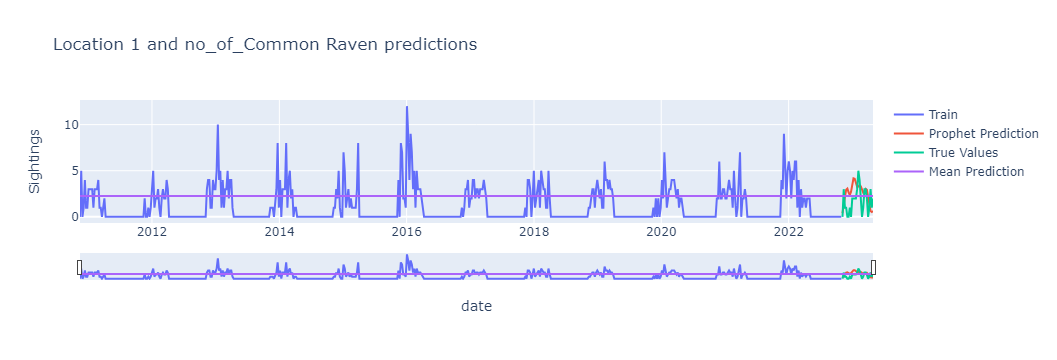

In [37]:
#Display plot for random selection of Location and Species

#Select random cluster (location) and random bird species
cluster = random.randint(0, 7)
selected_df = globals()[f'weekly_df_{cluster}']
bird = random.choice(selected_df.columns)

print(cluster)
print(bird)
#Create Plot
fig = go.Figure()
   
selected_train = globals()[f"train_{cluster}_{bird}"]
selected_test = globals()[f"test_{cluster}_{bird}"]
selected_pred = globals()[f"y_pred_{cluster}_{bird}"]
full_index = pd.concat([selected_train['ds'], selected_test['ds']])
baseline = globals()[f"baseline_{cluster}_{bird}"]


fig.add_trace(go.Scatter(x=selected_train['ds'], y=selected_train['y'], mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=selected_test['ds'], y=selected_pred['yhat'], mode='lines', name="Prophet Prediction"))
fig.add_trace(go.Scatter(x=selected_test['ds'], y=selected_test['y'], mode='lines', name="True Values"))
fig.add_trace(go.Scatter(x=full_index, y=baseline, mode='lines', name="Mean Prediction"))

fig.update_layout(
    yaxis_title="Sightings", 
    xaxis_title="Date",
    title= (f' Location {cluster} and {bird} predictions')
)

# activate slider
fig.update_xaxes(rangeslider_visible=True, title = "date")


fig.show()

***
[Back to Table of Contents](#ToC) 
***

### Part 3: Use Facebook Prophet to make predictions for 2024 <a class = "anchor" id = "Part-3"></a>

We will now use the entire span of the available dates to train our model, in order to make predictions for 2024. 

In [29]:
#Make predictions for 2024 and 2025

start_time = time.time()  # Start time
models = 0
cluster_predictions = {}  # Dictionary to store predictions for each cluster

for i in range(8): #loop through locations
    df = globals()[f"weekly_df_{i}"]
    filtered_df = df[
    (df.index.month.isin([11, 12, 1, 2, 3, 4])) & 
    (~((df.index.year == 2022) | (df.index.year == 2023) & (df.index.month.isin([11, 12, 1, 2, 3, 4])))
    )] #df with only the winter months, but not the months we will use in the test data (Avoid leakage!)
    
    
    for species in df.columns: #loop through all the columns (birdspecies) in one location
            
        #Get the prophet dataframe for each of the species defined in an earlier code bucket
        prophet_df = globals()[f"prophet_df_{i}_{species}"]

        #Create the Prediction Timeframe
        last_day = prophet_df['ds'].max() #Last day in the data
        next_day = last_day + pd.Timedelta(days=1)
        prediction_range = pd.date_range(start=next_day, end='2025-04-29', freq="D")
        prediction_range = pd.DataFrame(prediction_range, columns=['ds'])

        #Instantiate and train the model on the entire dataset
        globals()[f"model_24_{i}_{species}"] = Prophet()
        model = globals()[f"model_24_{i}_{species}"]
        model.fit(prophet_df)

        #Predict on test set
        globals()[f"y_pred_24_{i}_{species}"] = model.predict(prediction_range)
        y_pred_24= globals()[f"y_pred_24_{i}_{species}"]

        # Keep only necessary columns and rename 'yhat' to species name
        y_pred_subset = y_pred_24[['ds', 'yhat']].rename(columns={'yhat': species})

        # Store predictions in the cluster_predictions dictionary
        if i not in cluster_predictions:
            cluster_predictions[i] = y_pred_subset
        else:
            cluster_predictions[i] = pd.merge(cluster_predictions[i], y_pred_subset, on='ds')

        models = models + 1
        
    print(f' Cluster {i} done')
        

end_time = time.time()  # End time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")
print(f' {models} different Prophet models ran successfully')

09:05:38 - cmdstanpy - INFO - Chain [1] start processing
09:05:38 - cmdstanpy - INFO - Chain [1] done processing
09:05:39 - cmdstanpy - INFO - Chain [1] start processing
09:05:39 - cmdstanpy - INFO - Chain [1] done processing
09:05:39 - cmdstanpy - INFO - Chain [1] start processing
09:05:40 - cmdstanpy - INFO - Chain [1] done processing
09:05:40 - cmdstanpy - INFO - Chain [1] start processing
09:05:40 - cmdstanpy - INFO - Chain [1] done processing
09:05:40 - cmdstanpy - INFO - Chain [1] start processing
09:05:40 - cmdstanpy - INFO - Chain [1] done processing
09:05:41 - cmdstanpy - INFO - Chain [1] start processing
09:05:41 - cmdstanpy - INFO - Chain [1] done processing
09:05:41 - cmdstanpy - INFO - Chain [1] start processing
09:05:41 - cmdstanpy - INFO - Chain [1] done processing
09:05:42 - cmdstanpy - INFO - Chain [1] start processing
09:05:42 - cmdstanpy - INFO - Chain [1] done processing
09:05:42 - cmdstanpy - INFO - Chain [1] start processing
09:05:43 - cmdstanpy - INFO - Chain [1]

 Cluster 0 done


09:06:05 - cmdstanpy - INFO - Chain [1] start processing
09:06:05 - cmdstanpy - INFO - Chain [1] done processing
09:06:05 - cmdstanpy - INFO - Chain [1] start processing
09:06:06 - cmdstanpy - INFO - Chain [1] done processing
09:06:06 - cmdstanpy - INFO - Chain [1] start processing
09:06:06 - cmdstanpy - INFO - Chain [1] done processing
09:06:06 - cmdstanpy - INFO - Chain [1] start processing
09:06:06 - cmdstanpy - INFO - Chain [1] done processing
09:06:06 - cmdstanpy - INFO - Chain [1] start processing
09:06:06 - cmdstanpy - INFO - Chain [1] done processing
09:06:07 - cmdstanpy - INFO - Chain [1] start processing
09:06:07 - cmdstanpy - INFO - Chain [1] done processing
09:06:07 - cmdstanpy - INFO - Chain [1] start processing
09:06:07 - cmdstanpy - INFO - Chain [1] done processing
09:06:07 - cmdstanpy - INFO - Chain [1] start processing
09:06:07 - cmdstanpy - INFO - Chain [1] done processing
09:06:07 - cmdstanpy - INFO - Chain [1] start processing
09:06:07 - cmdstanpy - INFO - Chain [1]

 Cluster 1 done


09:06:26 - cmdstanpy - INFO - Chain [1] start processing
09:06:26 - cmdstanpy - INFO - Chain [1] done processing
09:06:26 - cmdstanpy - INFO - Chain [1] start processing
09:06:26 - cmdstanpy - INFO - Chain [1] done processing
09:06:26 - cmdstanpy - INFO - Chain [1] start processing
09:06:26 - cmdstanpy - INFO - Chain [1] done processing
09:06:27 - cmdstanpy - INFO - Chain [1] start processing
09:06:27 - cmdstanpy - INFO - Chain [1] done processing
09:06:27 - cmdstanpy - INFO - Chain [1] start processing
09:06:27 - cmdstanpy - INFO - Chain [1] done processing
09:06:27 - cmdstanpy - INFO - Chain [1] start processing
09:06:27 - cmdstanpy - INFO - Chain [1] done processing
09:06:27 - cmdstanpy - INFO - Chain [1] start processing
09:06:27 - cmdstanpy - INFO - Chain [1] done processing
09:06:28 - cmdstanpy - INFO - Chain [1] start processing
09:06:28 - cmdstanpy - INFO - Chain [1] done processing
09:06:28 - cmdstanpy - INFO - Chain [1] start processing
09:06:28 - cmdstanpy - INFO - Chain [1]

 Cluster 2 done


09:06:49 - cmdstanpy - INFO - Chain [1] start processing
09:06:49 - cmdstanpy - INFO - Chain [1] done processing
09:06:49 - cmdstanpy - INFO - Chain [1] start processing
09:06:50 - cmdstanpy - INFO - Chain [1] done processing
09:06:50 - cmdstanpy - INFO - Chain [1] start processing
09:06:50 - cmdstanpy - INFO - Chain [1] done processing
09:06:50 - cmdstanpy - INFO - Chain [1] start processing
09:06:50 - cmdstanpy - INFO - Chain [1] done processing
09:06:50 - cmdstanpy - INFO - Chain [1] start processing
09:06:51 - cmdstanpy - INFO - Chain [1] done processing
09:06:51 - cmdstanpy - INFO - Chain [1] start processing
09:06:51 - cmdstanpy - INFO - Chain [1] done processing
09:06:51 - cmdstanpy - INFO - Chain [1] start processing
09:06:51 - cmdstanpy - INFO - Chain [1] done processing
09:06:51 - cmdstanpy - INFO - Chain [1] start processing
09:06:51 - cmdstanpy - INFO - Chain [1] done processing
09:06:52 - cmdstanpy - INFO - Chain [1] start processing
09:06:52 - cmdstanpy - INFO - Chain [1]

 Cluster 3 done


09:07:14 - cmdstanpy - INFO - Chain [1] start processing
09:07:14 - cmdstanpy - INFO - Chain [1] done processing
09:07:14 - cmdstanpy - INFO - Chain [1] start processing
09:07:14 - cmdstanpy - INFO - Chain [1] done processing
09:07:15 - cmdstanpy - INFO - Chain [1] start processing
09:07:15 - cmdstanpy - INFO - Chain [1] done processing
09:07:15 - cmdstanpy - INFO - Chain [1] start processing
09:07:15 - cmdstanpy - INFO - Chain [1] done processing
09:07:15 - cmdstanpy - INFO - Chain [1] start processing
09:07:15 - cmdstanpy - INFO - Chain [1] done processing
09:07:15 - cmdstanpy - INFO - Chain [1] start processing
09:07:16 - cmdstanpy - INFO - Chain [1] done processing
09:07:16 - cmdstanpy - INFO - Chain [1] start processing
09:07:16 - cmdstanpy - INFO - Chain [1] done processing
09:07:16 - cmdstanpy - INFO - Chain [1] start processing
09:07:16 - cmdstanpy - INFO - Chain [1] done processing
09:07:16 - cmdstanpy - INFO - Chain [1] start processing
09:07:16 - cmdstanpy - INFO - Chain [1]

 Cluster 4 done


09:07:37 - cmdstanpy - INFO - Chain [1] start processing
09:07:37 - cmdstanpy - INFO - Chain [1] done processing
09:07:37 - cmdstanpy - INFO - Chain [1] start processing
09:07:37 - cmdstanpy - INFO - Chain [1] done processing
09:07:38 - cmdstanpy - INFO - Chain [1] start processing
09:07:38 - cmdstanpy - INFO - Chain [1] done processing
09:07:38 - cmdstanpy - INFO - Chain [1] start processing
09:07:38 - cmdstanpy - INFO - Chain [1] done processing
09:07:38 - cmdstanpy - INFO - Chain [1] start processing
09:07:38 - cmdstanpy - INFO - Chain [1] done processing
09:07:38 - cmdstanpy - INFO - Chain [1] start processing
09:07:38 - cmdstanpy - INFO - Chain [1] done processing
09:07:39 - cmdstanpy - INFO - Chain [1] start processing
09:07:39 - cmdstanpy - INFO - Chain [1] done processing
09:07:39 - cmdstanpy - INFO - Chain [1] start processing
09:07:39 - cmdstanpy - INFO - Chain [1] done processing
09:07:39 - cmdstanpy - INFO - Chain [1] start processing
09:07:39 - cmdstanpy - INFO - Chain [1]

 Cluster 5 done


09:07:56 - cmdstanpy - INFO - Chain [1] start processing
09:07:56 - cmdstanpy - INFO - Chain [1] done processing
09:07:56 - cmdstanpy - INFO - Chain [1] start processing
09:07:56 - cmdstanpy - INFO - Chain [1] done processing
09:07:56 - cmdstanpy - INFO - Chain [1] start processing
09:07:56 - cmdstanpy - INFO - Chain [1] done processing
09:07:57 - cmdstanpy - INFO - Chain [1] start processing
09:07:57 - cmdstanpy - INFO - Chain [1] done processing
09:07:57 - cmdstanpy - INFO - Chain [1] start processing
09:07:57 - cmdstanpy - INFO - Chain [1] done processing
09:07:57 - cmdstanpy - INFO - Chain [1] start processing
09:07:57 - cmdstanpy - INFO - Chain [1] done processing
09:07:57 - cmdstanpy - INFO - Chain [1] start processing
09:07:57 - cmdstanpy - INFO - Chain [1] done processing
09:07:58 - cmdstanpy - INFO - Chain [1] start processing
09:07:58 - cmdstanpy - INFO - Chain [1] done processing
09:07:58 - cmdstanpy - INFO - Chain [1] start processing
09:07:58 - cmdstanpy - INFO - Chain [1]

 Cluster 6 done


09:08:17 - cmdstanpy - INFO - Chain [1] start processing
09:08:17 - cmdstanpy - INFO - Chain [1] done processing
09:08:17 - cmdstanpy - INFO - Chain [1] start processing
09:08:18 - cmdstanpy - INFO - Chain [1] done processing
09:08:18 - cmdstanpy - INFO - Chain [1] start processing
09:08:18 - cmdstanpy - INFO - Chain [1] done processing
09:08:18 - cmdstanpy - INFO - Chain [1] start processing
09:08:18 - cmdstanpy - INFO - Chain [1] done processing
09:08:18 - cmdstanpy - INFO - Chain [1] start processing
09:08:18 - cmdstanpy - INFO - Chain [1] done processing
09:08:19 - cmdstanpy - INFO - Chain [1] start processing
09:08:19 - cmdstanpy - INFO - Chain [1] done processing
09:08:19 - cmdstanpy - INFO - Chain [1] start processing
09:08:19 - cmdstanpy - INFO - Chain [1] done processing
09:08:19 - cmdstanpy - INFO - Chain [1] start processing
09:08:19 - cmdstanpy - INFO - Chain [1] done processing
09:08:19 - cmdstanpy - INFO - Chain [1] start processing
09:08:19 - cmdstanpy - INFO - Chain [1]

 Cluster 7 done
Elapsed time: 170.8951072692871 seconds
 627 different Prophet models ran successfully


As before, we plot the predicictions for one bird species.

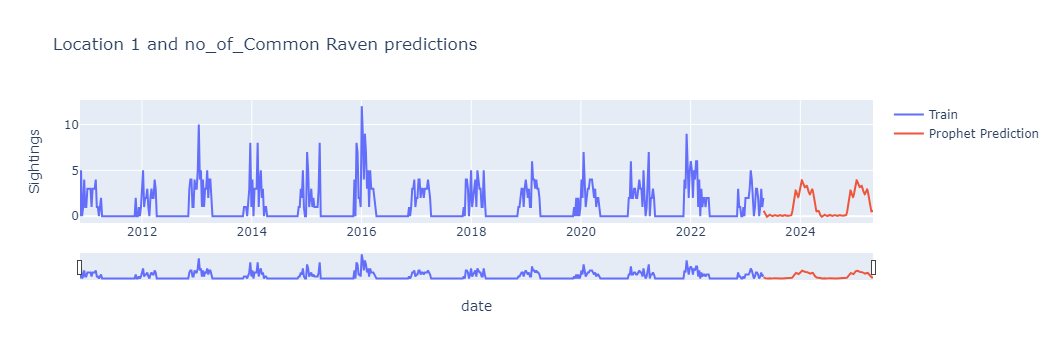

In [38]:
#Display plot for random selection of Location and Species (Same random selection as plot above)

prophet_df = globals()[f"prophet_df_{cluster}_{bird}"]
#Create Plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=prophet_df['ds'], y=prophet_df['y'], mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=cluster_predictions[cluster]['ds'], y=cluster_predictions[cluster][bird], mode='lines', name="Prophet Prediction"))

fig.update_layout(
    yaxis_title="Sightings", 
    xaxis_title="Date",
    title= (f' Location {cluster} and {bird} predictions in 2024 and 2025')
)

# activate slider
fig.update_xaxes(rangeslider_visible=True, title = "date")

fig.show()

We can now export the predictions to csv files.

In [39]:
#Export the data to 8 csv files, commented code to not export everytime the kernel is restarted

#for cluster_num, predictions_df in cluster_predictions.items():
    # Define the file name for each cluster's CSV file
    #file_name = f'cluster_{cluster_num}_predictions.csv'


    # Export the predictions DataFrame to a CSV file
    #predictions_df.to_csv(file_name, index=False)
